In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [13]:
#Likely will need to be updated
PATH = Path('data/weights')
JPEGS = "weight_images"
CSV_PATH_GOOGLE = PATH/'tmp/google_weights.csv'
CSV_PATH_COMBINED = PATH/'tmp/weights.csv'

In [14]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [15]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

In [16]:
f_model = resnet34
sz = 224
bs = 8

In [17]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
       RandomRotate(10, tfm_y=tfm_y),
       RandomLighting(0.1,0.1, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO, tfm_y=tfm_y)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV_PATH_COMBINED, tfms=tfms, continuous=True, bs=bs)

[   0.   92.  222.   66.]
[   1.   86.  222.   78.]
[   0.   84.  222.   81.]
[   1.   99.  219.   52.]
[   0.   89.  223.   73.]
[   1.   90.  222.   70.]
[   0.   89.  221.   72.]
[   1.   98.  219.   54.]
[   0.   81.  222.   88.]


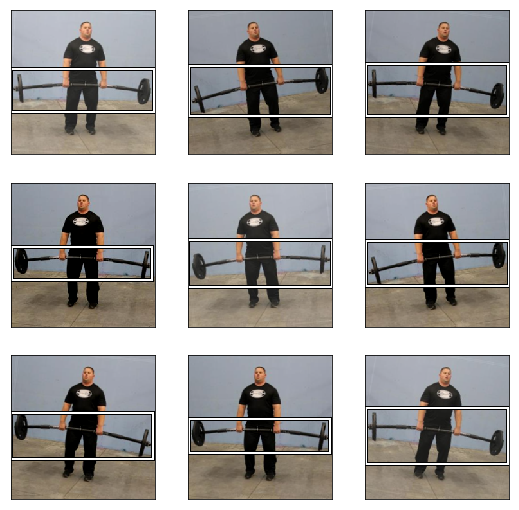

In [18]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [19]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088, 4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 37/50 [00:05<00:01,  7.39it/s, loss=381] 


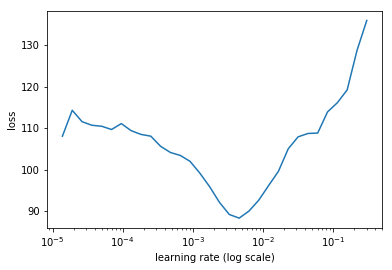

In [20]:
learn.lr_find(1e-5, 100)
learn.sched.plot(1, 5)

In [21]:
lr = 3e-4

In [22]:
learn.fit(lr, 3, cycle_len=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=21), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      50.106521  27.482122 
    1      26.505904  16.263206                           
    2      19.570164  15.993502                           
    3      16.081438  13.684621                           
    4      13.715712  11.79318                            
    5      12.18006   11.512114                           
    6      11.081115  11.611478                           
    7      10.444086  11.096667                           
    8      10.126644  11.072723                           
    9      10.391056  10.965898                           
    10     10.006884  10.802181                           
    11     9.379375   10.174189                           
    12     8.791422   10.125979                           
    13     8.406525   9.797955                            
    14     7.963816   9.528512                            
    15     7.629078   9.494554                            
    16     7.332809   9

[array([ 8.99251])]

In [13]:
lrs = np.array([lr/100, lr/10, lr])

In [14]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      70.328999  482179715657.0



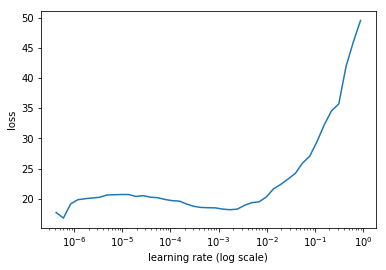

In [15]:
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [16]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      12.765178  13.506037 
    1      11.229432  11.844555                           
    2      9.665584   10.812177                           
    3      9.574297   11.228497                           
    4      8.871973   9.635204                            
    5      8.009221   9.46096                             
    6      7.49355    8.886258                            



[array([ 8.88626])]

In [17]:
learn.unfreeze()

In [18]:
learn.fit(lrs, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss                            
    0      7.961933   9.921624  
    1      7.883621   10.323358                           
    2      7.194524   9.680986                            
    3      7.195003   9.302903                            
    4      7.149022   9.497206                            
    5      6.522361   8.663824                            
    6      6.050116   8.542237                            
    7      6.31105    9.340817                            
    8      6.851504   8.155379                            
    9      6.528563   8.808847                            
    10     5.91224    7.967996                            
    11     5.546569   7.897598                            
    12     5.301273   7.629339                            
    13     4.976847   7.713123                            
    14     4.7825     7.749854                            
    15     5.183173   8.325003                            
    16     5.600804   8

[array([ 6.43455])]

In [19]:
x,y = next(iter(md.val_dl))
print(y)
learn.model.eval()
preds = to_np(learn.model(VV(x)))
# preds = to_np(learn.model((x)))
??VV


   55     0   137   212
   56    12    78   211
  127     1   221   223
   99     1   152   221
  123     4   216   220
  139     1   222   223
   51     0   129   223
  125     9   184   223
[torch.cuda.FloatTensor of size 8x4 (GPU 0)]



In [61]:
first = True
counter = 0
for x,y in iter(md.val_dl):
    if first:
        ret_y = y
        ret_x = x
        first = False
    else:
        ret_y = torch.cat((ret_y, y), dim=0)
        ret_x = torch.cat((ret_x, x), dim=0)

x = ret_x
y = ret_y
preds = to_np(learn.model(VV(x)))
print(len(preds))

98


In [54]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))


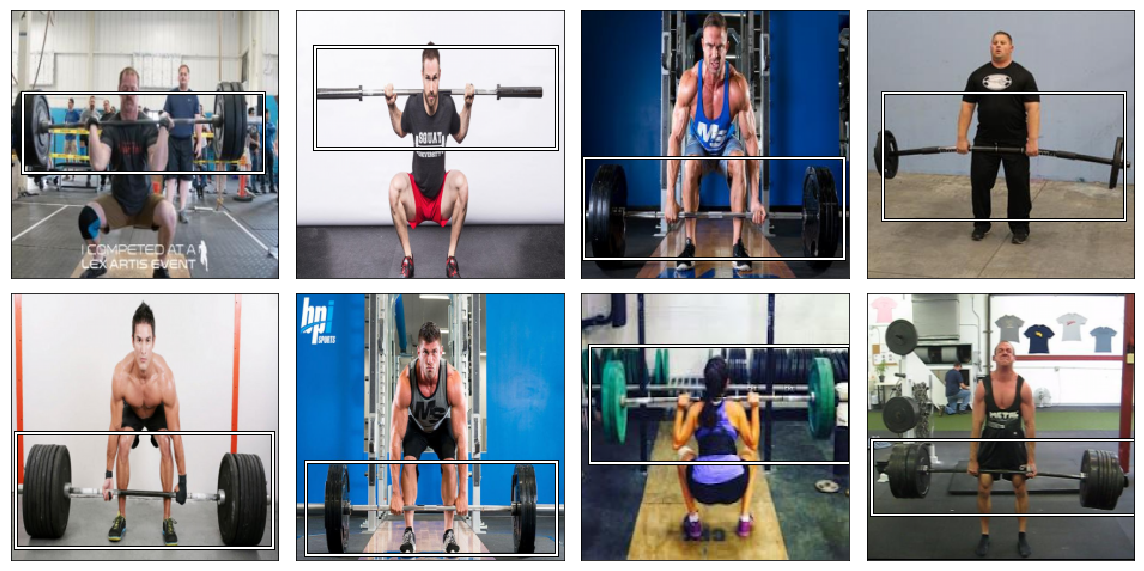

In [38]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

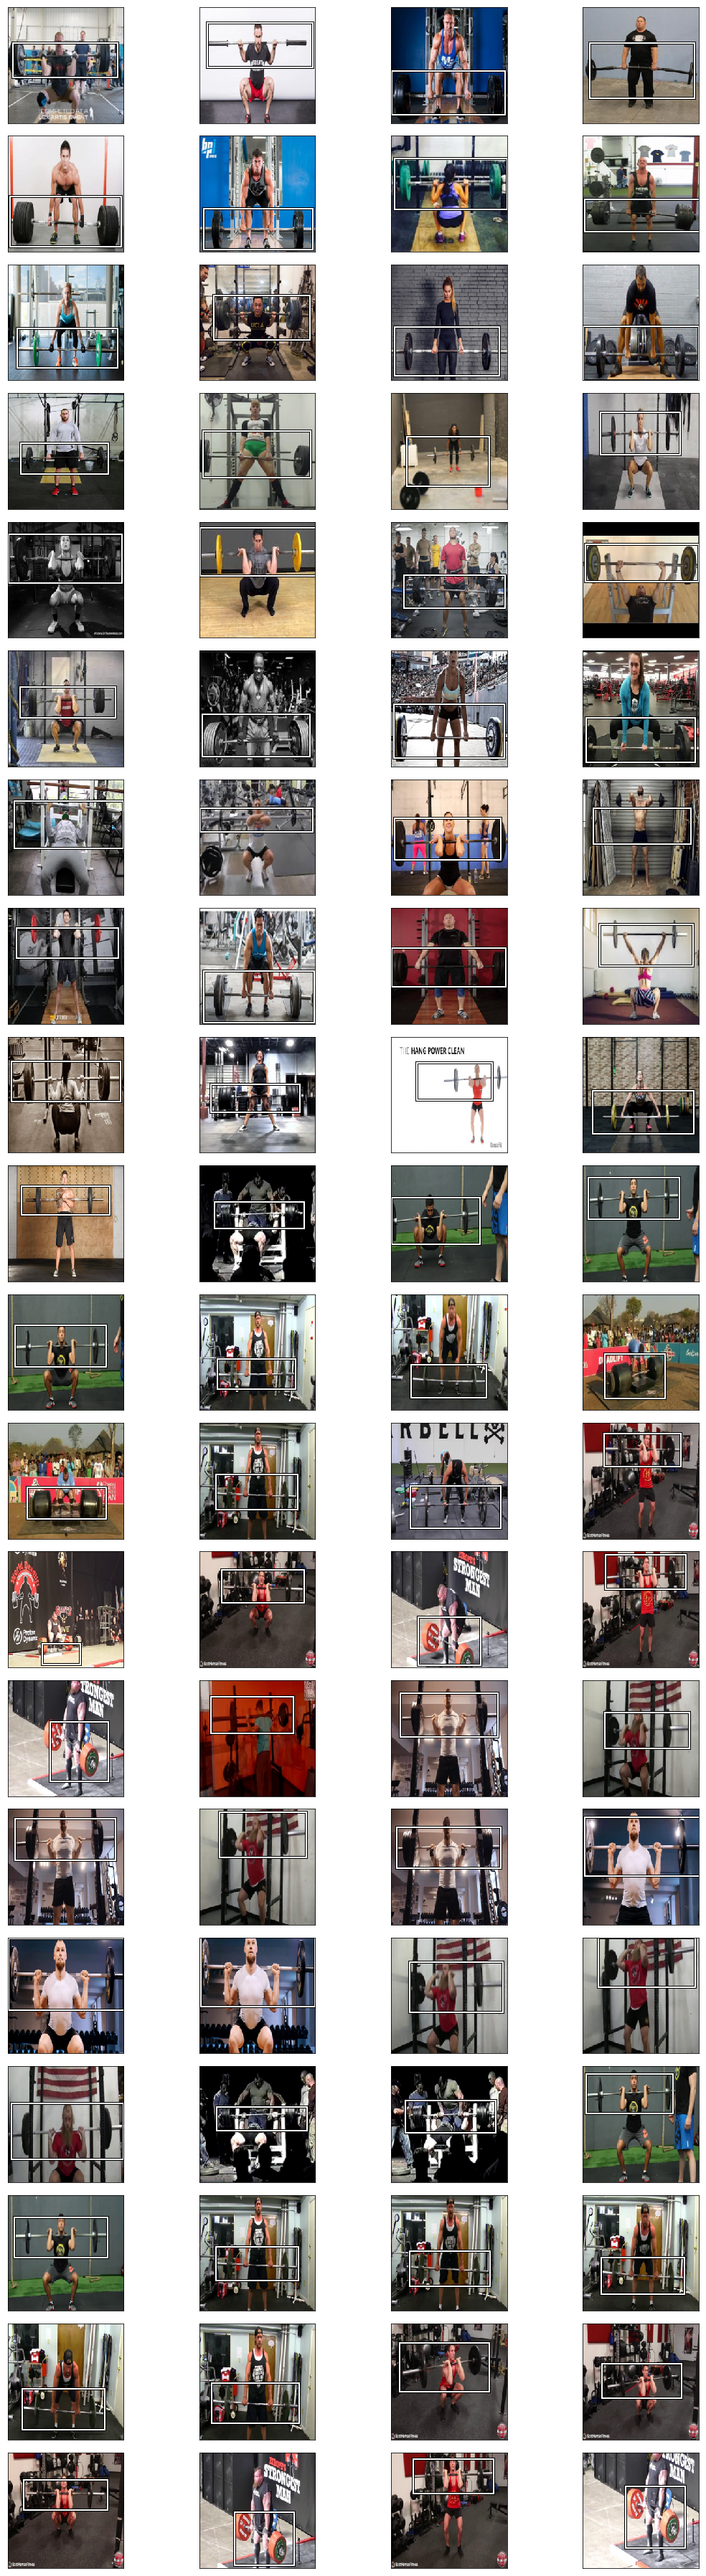

In [47]:
fig, axes = plt.subplots(20, 4, figsize=(16, 50))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

When using just google.  Also, function was still converging, so room for improvement.
    - 30     4.595181   5.328034
    
When using the combined data set, the finder function asks for a smaller learning rate (3e-4).  Gives us better performance overall.
    - 30     3.25948    3.946427 

In [81]:
ious = np.array(localization_accuracy(preds, to_np(y)))
print(len(ious[ious > .5]) / len(ious))
print(len(ious[ious > .6]) / len(ious))
print(len(ious[ious > .7]) / len(ious))
print(len(ious[ious > .8]) / len(ious))
print(len(ious[ious > .9]) / len(ious))

0.8979591836734694
0.8775510204081632
0.826530612244898
0.6938775510204082
0.25510204081632654


In [52]:
# accepts tensors or numpy arrays.  returns array equal to size of inputs / 4.  One iou measurement for each point.
def localization_accuracy(outputs, labels):
    
    if isinstance(outputs, torch.Tensor):
        outputs = outputs.numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.numpy()
    
    assert outputs.shape == labels.shape
    assert outputs.shape[1] % 4 == 0
    
    ret = []
    
    for i in range(len(outputs)):
        for j in range(0, outputs.shape[1], 4):
            bb1 = {'x1':outputs[i][j], 'y1': outputs[i][j+1], 'x2': outputs[i][j+2], 'y2': outputs[i][j+3]}
            bb2 = {'x1':labels[i][j], 'y1': labels[i][j+1], 'x2': labels[i][j+2], 'y2': labels[i][j+3]}
            ret.append(get_iou(bb1, bb2))
    return ret
            
    
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """

    if bb1['x1'] > bb1['x2'] or bb1['y1'] > bb1['y2'] or bb2['x1'] > bb2['x2'] or bb2['y1'] > bb2['y2']:
        return 0.0

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)   

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou 



# Everything past here is just to check
labels_full = np.array([[ 0.1130,  0.2602,  0.3219,  0.6352,  0.6760,  0.2630,  0.8198, 0.5407]])
outputs_full = np.array([[ 0.1130,  0.2602,  0.3219,  0.6352,  0.6760,  0.2630,  0.8198, 0.5407]])

labels_half = np.array([[ 0.4,  0.3,  0.6,  0.6]])
outputs_half = np.array([[ 0.4,  0.4,  0.6,  0.7]])

labels_quarter = np.array([[ 0.4,  0.4,  0.5,  0.5]])
outputs_quarter = np.array([[ 0.45,  0.45,  0.55,  0.55]])


labels_full = np.array([[ 1130,  2602,  3219,  6352,  6760,  2630,  8198, 5407]])
outputs_full = np.array([[ 1130,  2602,  3219,  6352,  6760,  2630,  8198, 5407]])

labels_half = np.array([[ 4,  3,  6,  6]])
outputs_half = np.array([[ 4,  4,  6,  7]])

labels_quarter = np.array([[ 40,  40,  50,  50]])
outputs_quarter = np.array([[ 45,  45,  55,  55]])

# Should be [1.0, 1.0]
print(localization_accuracy(labels_full, outputs_full))

# Should be [0.5]
print(localization_accuracy(labels_half, outputs_half))

#Should be 1/7 or 0.142
print(localization_accuracy(labels_quarter, outputs_quarter))


[1.0, 1.0]
[0.5]
[0.14285714285714285]
